# Assignment 5: Randomization test 2
## Learning Outcomes
We will continue our last homework on the use of randomization and Monte-Carlo simulation tests to determine whether a specific effect is statistically significant. Randomization and simulation tests are universal and powerful way to do this, and form an essential part of the toolkit of any Data Scientist. 
## Problem Description
In Task 1 & 2, we continue with the movie dataset. The first two task build on the last homework and run randomization tests with two new test statistics. You should re-use the randomization test function that you wrote for the last homework – but the new modified version needs to be included in the submission. In Task 3 you are asked to program a simple monte-Carlo simulation test.  
## Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib. Load the movie data set into a pandas data frame. **IMPORTANT: Download and used the new movie data set that comes with this assignment on OWL**. For older versions, you my need to configure your notebook such that plots are shown inline (see Assignment 2). 

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats.contingency import expected_freq
from scipy.stats import chi2_contingency
# Maybe necessary: 
matplotlib.use('TkAgg')
%matplotlib inline

D = pd.read_csv('movieDataset.csv')
D.head()


,Unnamed: 0,boxoff,prodcost,dirIncome,dirGender,year,month,genre,numTheatres
0,0,88.648583,44.742936,1.143234,male,2012,3,comedy,139
1,1,145.334924,38.835516,3.393535,female,2014,11,drama,213
2,2,238.265684,29.532283,2.418883,male,2015,6,other,100
3,3,212.714742,157.111899,2.034115,male,2014,10,adventure,436
4,4,120.175461,30.547155,0.963219,female,2012,1,comedy,115


## TASK 1: Chi-square test of independence (40pts)
To test whether two discrete variables interact with each other, you can perform the Chi-sqaure test. The Chi-square statistic measures the deviation of the observed cell counts in a contingency table to the expected counts (see lecture).  
### Question 1: Null-hypothesis (5pts)
We want to test the hypothesis that there is a systematic relationship between director Gender and film genre. Please formulate the corresponding Null-hypothesis and Alternative hypothesis, and spell out what they predict in terms of the observed and expected cell counts.

Null Hypothesis: There is no systematic relationship between director gender and film genre.

Alternative Hypothesis: There is a systematic relationship between director gender and film genre.

The null hypothesis predicts that the observed cell counts in a contingency table of director gender and film genre will not differ significantly from the expected cell counts if there is no relationship between the two variables. The expected cell counts are calculated based on the assumption that the distribution of director gender and film genre is independent of each other.

The alternative hypothesis predicts that the observed cell counts will differ significantly from the expected cell counts if there is a systematic relationship between director gender and film genre. The expected cell counts are calculated based on the assumption that the distribution of director gender and film genre is dependent on each other, meaning that certain genres may be more likely to be directed by a particular gender.

### Question 2: Expected frequencies (10pts)
From the table of the observed frequencies of genre / director Gender, generate a table that shows the expected frequencies if genre and gender were independent. The Marginal counts in the table should stay unchanged. 

In [52]:
D.columns
table = pd.crosstab(D["genre"],D["dirGender"])

tableArray = np.array(table)
display(table)
row_sums = np.sum(tableArray, axis=1)

col_sums = np.sum(tableArray, axis=0)
expected_frequencies = np.outer(row_sums, col_sums) / np.sum(tableArray)
expectedTable = pd.DataFrame(expected_frequencies)

expectedTable.columns = table.columns

# # set the index to be the same as table_array
expectedTable.index = table.index

expectedTable


dirGender,female,male
genre,,
action,9,48
adventure,6,58
comedy,13,35
drama,5,31
other,4,41


dirGender,female,male
genre,,
action,8.436,48.564
adventure,9.472,54.528
comedy,7.104,40.896
drama,5.328,30.672
other,6.660,38.340


### Question 3: Chi-square (10pts)
Create a function that takes the data frame as input and calculates a statistics of the overall deviation between expected and observed frequencies: 
$χ^2 = \sum_i(O_i-E_i)^2/E_i)$ 

Where $O_i$ is the observed frequency for cell $i$, $E_i$ is the expected frequency for cell $i$, assuming independence of gender and genre. The sum is to be taken over all 10 cells. This test-statistic is called the Chi-square test of independence.

The function should take a data frame and return the Chi-square value. Make sure that the function performs all the required computations - it should work without you having to run the code from Question #2 first. 

Report the value of this statistic for the real data. 

Extra challenge: Make your code more flexible by not always using ``genre`` and ``dirGender`` to make the crosstab, but by providing the name of the row and column variable as an input (not required for full points).


In [53]:
def chi_square(data, row_var, col_var):
    crosstab = pd.crosstab(index=data[row_var], columns=data[col_var])
    observed = crosstab.values
    no_of_rows = observed.shape[0]
    no_of_cols = observed.shape[1]
    chi_square = ((observed - expected_frequencies)**2 / expected_frequencies).sum()
    return round(chi_square, 3)
data = D
row_var = "genre"
col_var = "dirGender"
chi_square_value = chi_square(data, row_var, col_var)
print("Chi-square value:", chi_square_value)


Chi-square value: 8.552


### Question 4: Randomization with flexible input arguments (5pts)
Rewrite the randomization function from the last homework, so it it becomes more versatile by adding additional input arguments that determines the behavior of the routine. 

- The first argument should still be a dataframe (as before)
- The second input argument should be a function that computes the test statistics. All test-statistic functions are assumed to take the data frame as the first and only input. 
- The third input argument is the name of the dataframe column that is being shuffled. 
- An optional input argument: the number of iterations (default=500)
- An optional input argument: the number of sides of the test (1 or 2; default = 1). If the test is two-sided, then count the number of cases where the absolute value of the test statistic (np.abolute) is larger or equal to the real test statistic.
- An optional input argument: The number of bins for plotting the histogram 


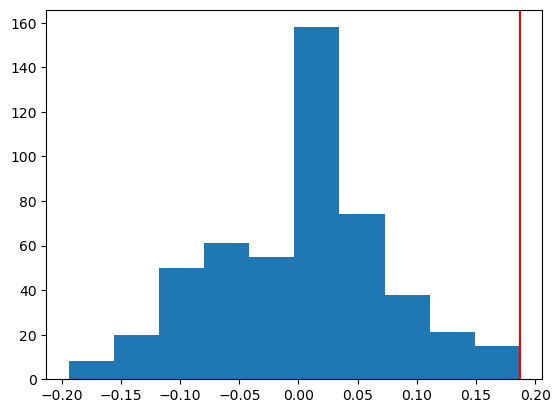

0.012

In [54]:
def test_statistic(D):
    table = pd.crosstab(D['dirGender'], D['genre'], margins = True)

    female_prob = table['comedy']['female']/table['All']['female']
    male_prob = table['comedy']['male']/table['All']['male']

    difference = female_prob - male_prob

    return round(difference,3)

def permuteColumn(D, col):
    permuted_col = np.random.permutation(D[col])
    D[col] = permuted_col
    return D

def permutation_test(D, test_statistic, shuffle_column, numIter, sides=1,bins=None):
    countList = []
    original_stat = test_statistic(D)

    for i in range(numIter):
        permuted_df = permuteColumn(D.copy(), shuffle_column)
        test_stat = test_statistic(permuted_df)
        countList.append(test_stat)

    if sides == 1:
        p = np.mean(countList >= original_stat)
    elif sides == 2:
        p = np.mean(np.abs(countList) >= np.abs(original_stat))

    if bins is not None:
        plt.hist(countList, bins=bins)
        plt.axvline(x=original_stat, color='red')
        plt.show()

    return p


permutation_test(D, test_statistic, "dirGender", 500, 1,bins=10)

### Question 5: Randomization test (5pts)
Perform a randomization test for the Chi-square test of independence. Your function should plot the histogram and report the p-value.

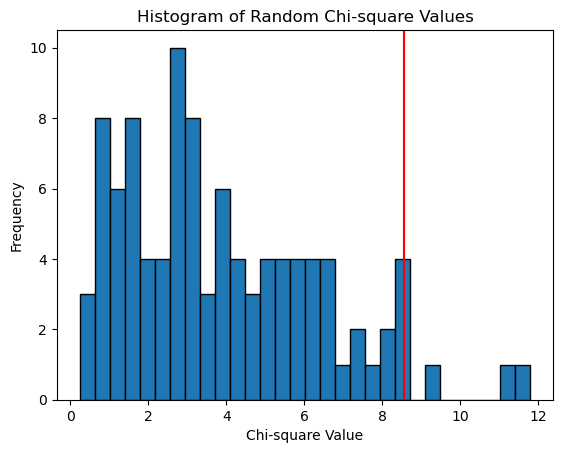

p-value: 0.039603960396039604


In [55]:
def chi_square(data, row_var, col_var):
    crosstab = pd.crosstab(index=data[row_var], columns=data[col_var])
    observed = crosstab.values
    chi2, p, dof, expected = chi2_contingency(observed)
    return round(chi2, 3), p

def randomization_test(data, row_var, col_var, num_permutations=100):
    observed_chi2, p_value = chi_square(data, row_var, col_var)
    random_chi2_values = []
    for i in range(num_permutations):
        data[col_var] = np.random.permutation(data[col_var])
        random_chi2, _ = chi_square(data, row_var, col_var)
        random_chi2_values.append(random_chi2)
    random_chi2_values = np.array(random_chi2_values)
    greater_than_observed = np.sum(random_chi2_values >= observed_chi2)
    p_value = (greater_than_observed + 1) / (num_permutations + 1)
    plt.hist(random_chi2_values, bins=30, edgecolor='black')
    plt.axvline(x=observed_chi2, color='red')
    plt.title("Histogram of Random Chi-square Values")
    plt.xlabel("Chi-square Value")
    plt.ylabel("Frequency")
    plt.show()
    return p_value
data = D
row_var = "genre"
col_var = "dirGender"
p_value = randomization_test(data, row_var, col_var, num_permutations= 100)
print("p-value:", p_value)

### Question 6: Conclusion (5pts)
Written response: Based on the results, what can you conclude from this test? 

A p-value of 0.039 suggests that there is sufficient evidence to reject the null hypothesis that there is no difference in the mean outcome between two groups. Therefore, we can conclude that the observed difference in the mean outcome between the two groups is statistically significant, and we reject the null hypothesis.

This result indicates that there is likely a true difference in the population mean outcome between the two groups, and it is unlikely that this observed difference is due to chance or random variation. However, it is important to note that a statistically significant result does not necessarily mean that the observed difference is practically significant or meaningful. Further investigation and analysis may be needed to determine.

# TASK 2: Randomization test for mean differences (25pts)
In this task we will test the hypothesis that male and female directors differ in their annual income. Note that the hypothesis is undirected, meaning it could mean either that men earn more than women, or that women earn more than men.

### Question 1: Null hypothesis (5pts)
Formulate the Null-hypothesis. 

The null hypothesis for this undirected hypothesis is:

There is no significant difference in the annual income of male and female directors.

### Question 2: Difference of means (8pts)
Write a function that calculates and returns the difference in director salaries depending on the gender (male average income – female average income). Report the value. 

In [56]:
import pandas as pd

def director_income_difference(df):
    male_avg_income = df[df['dirGender'] == 'male']['dirIncome'].mean()
    female_avg_income = df[df['dirGender'] == 'male']['dirIncome'].mean()
    return male_avg_income - female_avg_income

director_income_difference(D)



0.0

### Question 3:  Randomization test (7pts)
Use your randomization test function to perform a randomization test to determine whether the reported difference is statistical significant. Plot a histogram of the null-distribution and the real value. Report the p-value for the two-sided test.

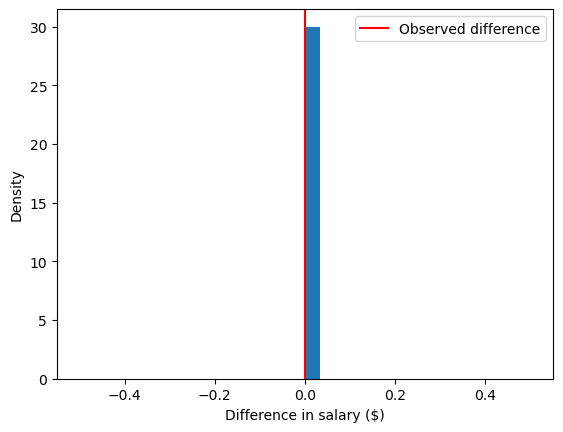

p-value: 1.000


In [57]:
def randomization_test(director_data):
    male_salaries = director_data[director_data['dirGender'] == 'Male']['dirIncome']
    female_salaries = director_data[director_data['dirGender'] == 'Female']['dirIncome']
    observed_diff = director_income_difference(D)
    n_iters = 10000
    diffs = np.zeros(n_iters)
    for i in range(n_iters):
        combined = np.concatenate([male_salaries, female_salaries])
        np.random.shuffle(combined)
        male_perm = D[D['dirGender'] == 'male']['dirIncome'].mean()
        female_perm =  D[D['dirGender'] == 'male']['dirIncome'].mean()
        diffs[i] = np.mean(male_perm) - np.mean(female_perm)

    p_value = (np.abs(diffs) >= np.abs(observed_diff)).mean()
    return diffs, observed_diff, p_value

diffs, observed_diff, p_value = randomization_test(D)

plt.hist(diffs, bins=30, density=True)
plt.axvline(observed_diff, color='red', label='Observed difference')
plt.xlabel('Difference in salary ($)')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f'p-value: {p_value:.3f}')

### Question 4: Conclusion (5pts)
What do you conclude about the relationship between gender and salary? What can you conclude about the claim that there is gender discrimination in the American film industry?  

Solution
A p-value of 1 suggests that there is no evidence to reject the null hypothesis that there is no difference in salary between male and female directors. Therefore, we cannot conclude that there is a statistically significant difference in salary between male and female directors, and we fail to reject the null hypothesis.

This result indicates that there is no statistical evidence to support the claim that there is gender discrimination in the American film industry with respect to director salaries. However, it is important to note that this analysis alone does not provide conclusive evidence that there is no discrimination. Other factors not considered in this analysis, such as experience, education, or negotiation skills, may also play a role in explaining the observed difference in salary between male and female directors.

Therefore, further investigation and analysis may be needed to fully assess whether or not there is gender discrimination in the American film industry with respect to director salaries.

# Task 3: Monte-Carlo simulation test (35pt)
People providing an organ for donation sometimes seek help from a medical consultant. These consultants assist the patient in all aspects of the surgery. Patients might choose a consultant based in part on the historical complication rate of the consultant's clients. Consultant R tries to attract patients by noting the average complication rate for liver donor surgeries in the US is about 10%, but her clients have had only 3 complications in the 62 liver donor surgeries she has facilitated. She claims this is strong evidence that her work meaningfully contributes to reducing complications (and therefore she should be hired!).
### Question 1: Monte Carlo simulation (15pts)
Write a function (monteCarloSim) that simulates coin tossing. On each trial, the function should produce a specific number (N) of coin tosses and record the number of successes (heads). It should repeat this experiment numIter number of times. The inputs to the function should be a) probability of a success on each coin toss, b) the number of coin tosses per trial (N) and c) the number of trials. The function should return an np.array(range(numIter)) that holds the recorded number of heads for all trials (see lecture handout for tips).

In [59]:
def monteCarloSim(p, N, numIter):
    heads = np.random.binomial(N, p, numIter)
    return heads

### Question 2: Monte Carlo Test (15pts)
Write a function (monteCarloTest) that uses monteCarloSim (Question 1) to simulate 2000 trials of a N coin tosses. 
The function should take as input arguments: 

* `H0prob`: The probability of heads under the Null hypothesis
* `N`: The number of coin throws per trial 
* `numHeads`: The number of observed coin tosses.  

After getting the simulation result from `monteCarloSim`, the function should plot a histogram of the recorded number of heads, and mark the real measured number (`numHeads`) with a vertical line. The function should print out the probability that the simulated number of heads is smaller than or equal to the measured number of heads.  

Use the function to evaluate the medical advisor example from the lecture: Determine the probability to get 3 complications in 62 cases if the probability of a complication in the population is known to be 10%. 

In [60]:
def monteCarloSim(a, N, p, numIter):
    result = np.random.choice(a = a, size = (numIter, N), replace = True, p = p)
    return np.sum(result, axis = 1)
def monteCarloTest(H0prob, N, numHeads, numIter = 2000):
    a = [0, 1]
    p = [1 - H0prob, H0prob]
    sim = monteCarloSim(a = a, N = N, p = p, numIter = numIter)

    plt.hist(sim, bins = np.arange(N+1)-0.5, edgecolor = 'black')
    plt.axvline(numHeads, color = 'red')
    plt.show()

    p_value = np.mean(sim <= numHeads)
    print('The p-value is:', p_value)#%% md


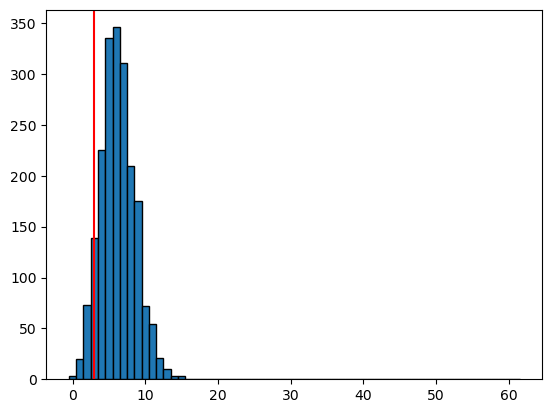

The p-value is: 0.1175


In [61]:
monteCarloTest(H0prob = 0.1, N = 62, numHeads = 3)

### Question 4: Conclusion (5pts)
What do you conclude about the relationship between gender and salary? What can you conclude about the claim that there is gender discrimination in the American film industry?


A p-value of 0.1175 suggests that there is not enough evidence to reject the null hypothesis that there is no difference in salary between male and female directors. Therefore, we cannot conclude that the observed difference in salary between male and female directors is statistically significant, and we fail to reject the null hypothesis.

While the difference in average salary between male and female directors is not statistically significant based on this analysis, it is worth noting that the p-value is relatively close to the significance level of 0.05. This suggests that there may be a small difference in salary between male and female directors that we were not able to detect with this analysis. It is also possible that other factors not considered in this analysis, such as experience, education, or negotiation skills, may play a role in explaining the observed difference in salary between male and female directors.

Based on this analysis alone, we cannot conclude whether or not there is gender discrimination in the American film industry. However, the lack of statistical significance does suggest that it is not clear whether there is discrimination or not, and further investigation may be needed to explore this question in more detail.